## Imports

In [45]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 
from sklearn.metrics import confusion_matrix
import torch
import pandas as pd
from datasets import Dataset
import seaborn as sns

In [46]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

id2label = {0: "CONTROL", 1: "BROCA"}
label2id = {"CONTROL": 0, "BROCA": 0}

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
dataset_filename = "input.csv"
data = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop('Unnamed: 0', axis=1)

In [49]:
data["label"].value_counts()

label
0    40316
1    14337
Name: count, dtype: int64

In [50]:
dataset = Dataset.from_pandas(data)

In [51]:
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    return metric_res

In [52]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [53]:
tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/54653 [00:00<?, ? examples/s]

In [54]:
tokenized_data_split = tokenized_data.train_test_split(test_size=0.2, seed=42)

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: ylabel='count'>

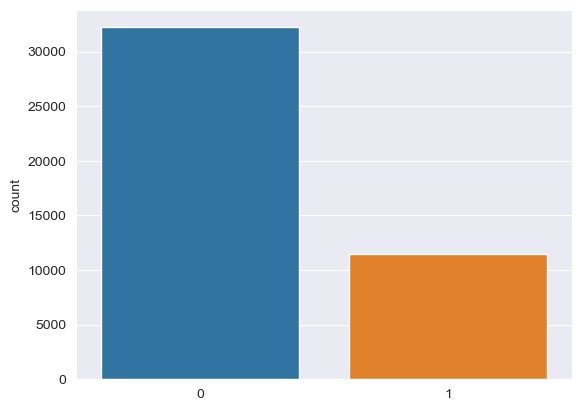

In [55]:
sns.countplot(x=tokenized_data_split['train']['label'])

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: ylabel='count'>

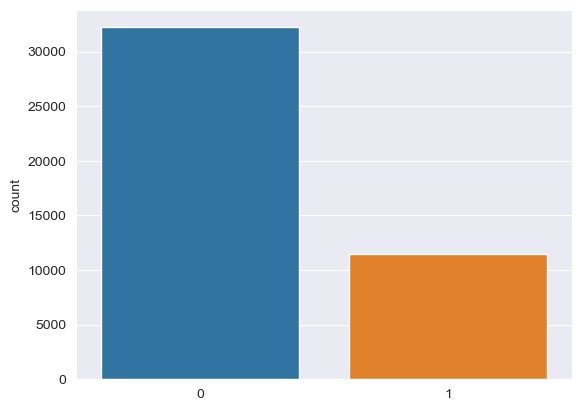

In [56]:
sns.countplot(x=tokenized_data_split['train']['label'])

In [57]:
training_args = TrainingArguments(
    output_dir="bert_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    use_cpu = False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_split["train"],
    eval_dataset=tokenized_data_split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# trainer.train()
# trainer.save_model('bert_finetuned')

Epoch,Training Loss,Validation Loss


In [58]:
trainer.evaluate()

{'eval_loss': 0.20850302278995514,
 'eval_accuracy': 0.9176653554112159,
 'eval_recall': 0.8338624338624339,
 'eval_precision': 0.8464017185821697,
 'eval_f1': 0.8400852878464818,
 'eval_runtime': 12.3414,
 'eval_samples_per_second': 885.717,
 'eval_steps_per_second': 55.423,
 'epoch': 2.0}

# Evaluate model

In [68]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("bert_finetuned")
model = AutoModelForSequenceClassification.from_pretrained("bert_finetuned")

In [60]:
sentences = tokenized_data_split["test"]["text"]
true_labels = tokenized_data_split["test"]["label"] 

In [62]:
pred_labels = []

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt")
    
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    pred_labels.append(predicted_class_id)


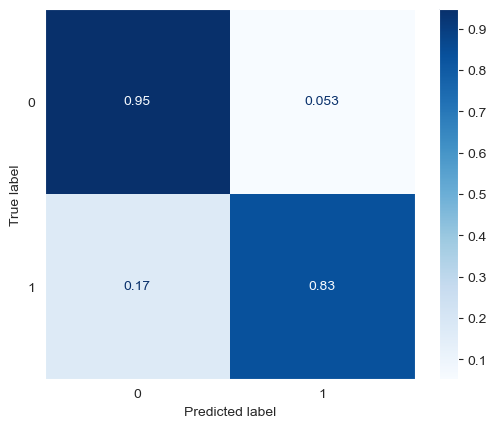

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [67]:
accuracy_score(true_labels, pred_labels)

0.9176653554112159

# Example evaluate on synthetic data

In [71]:
# Sentence from prompt engineering
inputs1 = tokenizer("Uh, see, um, blue car. Fast, uh, on road.", return_tensors="pt")

# Sentence from (ongoing) linguistic model
inputs2= tokenizer("oh I want ah er apple ah", return_tensors="pt")

# Sentence from C4
inputs3= tokenizer("Embrace world class facilities at East Bourne Resort & Spa Shimla", return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs3).logits
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]


'CONTROL'